In [1]:
import time
import tkinter as tk

import habitat
from PIL import Image, ImageTk
import numpy as np
import cv2
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.maps import calculate_meters_per_pixel
from habitat.utils.visualizations.utils import tile_images, draw_collision
import torch
from habitat_baselines.common.baseline_registry import baseline_registry
from emb_transfer.er_env import *
from emb_transfer.er_task import *
from emb_transfer.er_imagenav_task import *
from emb_transfer.er_ppo import *

from habitat_baselines.common.obs_transformers import (
    apply_obs_transforms_batch,
    apply_obs_transforms_obs_space,
    get_active_obs_transforms,
)
from habitat_baselines.utils.common import batch_obs

import os

os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"
os.chdir('/srv/flash1/pputta7/projects/lm-nav/')

In [2]:
from lmnav.emb_transfer.old_eai_policy_2_2 import EAIPolicy

device = 'cuda'
torch.set_grad_enabled(False)

teacher_ckpt = "/coc/testnvme/pputta7/.experiments/embodiment-transfer/202304171546-jzPl/out/new_checkpoints/ckpt.300.pth"
# teacher_ckpt = '/coc/testnvme/pputta7/.experiments/embodiment-transfer/202303101243-ywgG/out/new_checkpoints/ckpt.150.pth'
ckpt_dict = torch.load(teacher_ckpt)

In [3]:
config = ckpt_dict['config']
config.defrost()
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ['00540-6nvpJEZ8ox5']
config.freeze()

policy = baseline_registry.get_policy(config.RL.POLICY.name)
env = ImagenavEmbodimentTransferRLEnv(config=config.TASK_CONFIG)

2023-08-31 01:04:37,443 Initializing dataset ERNavDynamicAgentLoading-v1
2023-08-31 01:04:38,696 initializing sim Sim-v0
2023-08-31 01:04:40,261 Initializing task ERImageNav-v0


In [4]:
observation_space = env.observation_space
obs_transforms = get_active_obs_transforms(config)
obs_transforms[0].trans_keys = ('rgb', 'imagegoalrotation', 'depth')
observation_space = apply_obs_transforms_obs_space(
    observation_space, obs_transforms
)

actor_critic = policy.from_config(
    config, observation_space, env.action_space
)
obs_space = observation_space
actor_critic.to('cuda')
ppo_cfg = config.RL.PPO
agent = ER_PPO(
            actor_critic=actor_critic,
            clip_param=ppo_cfg.clip_param,
            ppo_epoch=ppo_cfg.ppo_epoch,
            num_mini_batch=ppo_cfg.num_mini_batch,
            value_loss_coef=ppo_cfg.value_loss_coef,
            entropy_coef=ppo_cfg.entropy_coef,
            lr=ppo_cfg.lr,
            encoder_lr=ppo_cfg.encoder_lr,
            wd=ppo_cfg.wd,
            eps=ppo_cfg.eps,
            max_grad_norm=ppo_cfg.max_grad_norm,
            use_normalized_advantage=ppo_cfg.use_normalized_advantage,
        )

2023-08-31 01:04:40,274 Resizing observation of depth: from (480, 640) to (120, 160)
2023-08-31 01:04:40,275 Resizing observation of imagegoalrotation: from (480, 640) to (120, 160)
2023-08-31 01:04:40,277 Resizing observation of rgb: from (480, 640) to (120, 160)
2023-08-31 01:04:43,495 Using weights from /srv/flash1/rramrakhya6/summer_2022/mae-for-eai/data/visual_encoders/mae_vit_small_decoder_large_HGPS_RE10K_100.pth: _IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_token', 'decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'de

In [5]:
agent.load_state_dict(ckpt_dict["state_dict"])

<All keys matched successfully>

In [6]:
observation_space

Dict('depth': Box(0.0, 1.0, (120, 160, 1), float32), 'imagegoalrotation': Box(0, 255, (120, 160, 3), uint8), 'rgb': Box(0, 255, (120, 160, 3), uint8))

In [27]:
def batch_to(device):
    batch['rgb'] = batch['rgb'].to(device)
    batch['depth'] = batch['depth'].to(device)
    batch['imagegoalrotation'] = batch['imagegoalrotation'].to(device)
    
rnn_hidden_states = torch.zeros((1, 2, 512), device=device)
prev_actions = torch.zeros(1, 1, device=device, dtype=torch.long)
not_done_masks = torch.ones(1, 1, device=device, dtype=torch.bool)
rgb_frames = []

In [28]:
observations = env.reset()

In [29]:
step = 0
done = False

while step < 500 and not done:
    # batch data up
    batch = batch_obs([observations])
    batch = apply_obs_transforms_batch(batch, obs_transforms)
    batch_to('cuda')

    rgb_frames.append(observations['rgb'].copy())
    goal = observations['imagegoalrotation']
    
    # query policy for next action
    features, rnn_hidden_states = agent.actor_critic.net(batch,
                                           rnn_hidden_states,
                                           prev_actions,
                                           not_done_masks)
    dist = agent.actor_critic.action_distribution(features)
    action = dist.mode()
    print(action)
    prev_actions.copy_(action)

    # pass data through environment
    observations, rewards, done, infos = env.step(action.item())
    step += 1

tensor([[2]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[3]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[2]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([[1]], device='cuda:0')
tensor([

In [31]:
import cv2

imgs = rgb_frames

# Get the list of images
# Create the video writer
video_writer = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 24, (imgs[0].shape[1], imgs[0].shape[0]))

# Write the images to the video writer
for image in imgs:
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    video_writer.write(image)

# Close the video writer
video_writer.release()

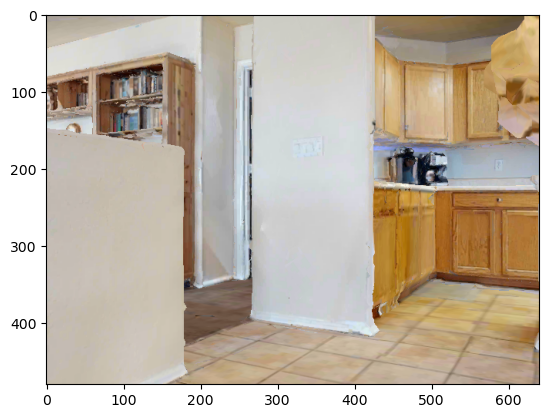

In [32]:
from matplotlib import pyplot as plt

plt.imshow(goal)